In [147]:
%load_ext autoreload
%autoreload 2
import numpy as np
import collections
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
from utils import load_results
from utils import precision_recall_scores as roc
from utils import mpl_stylesheet
from utils import utils
# mpl_stylesheet.banskt_presentation(fontfamily = 'system')
from functools import wraps
import time

def timeit(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print('{:s} took: {:.6f} seconds'.format(f.__name__, te-ts))
        return result
    return wrap


def get_dict_for_method(method, input_dir, chrms, tissue, sb = '0.01', replica = 1):
    chrmdicts = [dict() for c in chrms]
    datadir = os.path.join(input_dir, tissue, str(replica))
    print("Reading {:s} for {:s} in replica {:d}".format(tissue, method, replica))
    for i, chrm in enumerate(chrms):
        if method.startswith('tejaas_part'):
            filepath = os.path.join(datadir, method, 'permnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            print("Loading ", filepath)
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method.startswith('matrixeqtl'):
            filepath = os.path.join(datadir, method, 'chr{:d}'.format(chrm), 'trans_eqtl.txt')
            print("Loading ", filepath)
            chrmdicts[i] = load_results.matrixeqtl(filepath)

    res = dict()
    for d in chrmdicts:
        for k, v in d.items():
            res[k] = v
    return res


INFO_FIELDS = ['rsid', 'stat', 'causality']
class ValidateResult(collections.namedtuple('_ValidateResult', INFO_FIELDS)):
    __slots__ = ()


@timeit
def validate(testdict, valdict, smax = -np.log10(0.05), nmax = None, empirical = False, empirical_percent = 5):
    if empirical:
        percent_fraction = 100/empirical_percent
        if nmax is None:
            totsnps = len(list(testdict.keys()))
            nmax = int(np.round(totsnps/percent_fraction))
            print("totsnps:", totsnps, " nmax:", nmax)
        sorted_snps = [x[0] for x in sorted(valdict.items(), key=lambda x: x[1], reverse = True)]
        topsnps = sorted_snps[:nmax]
    else:
        topsnps = [k for k,v in valdict.items() if v > smax]
    data = dict()
    for key, value in testdict.items():
        data[key] = ValidateResult(rsid = key, stat = value, causality = 0)
    for key in topsnps:
        if key in data:
            data[key] = ValidateResult(rsid = key, stat = data[key].stat, causality = 1)
    datalist = list(data.values())
    return datalist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
import itertools 

chrms = [6, 7, 8]
replicas = np.arange(1,6)
replicas = [1]
# chrms = np.arange(1,23)
datasets = ['gtex-wb']
methods = [ 'matrixeqtl_part1', 'matrixeqtl_part2', 'tejaas_part1', 'tejaas_part2']
pairs = [ ('matrixeqtl_part1', 'matrixeqtl_part2'), ('tejaas_part1', 'tejaas_part2')]
sbs = ["0.01"]
eps = [1]
expressions = ["lmcorrected", "lmcorrected_age", "peer10", "peer10age"]
expr = expressions[2]
input_dir = '/cbscratch/franco/trans-eqtl/dev-pipeline/parttest/'+expr


In [149]:
# Load all datasets first
allmethods = list()
data = collections.defaultdict(dict)
for dataset in datasets:
    for r in replicas:
        data[dataset][r] = collections.defaultdict(dict)
        for key in methods:
            if key.startswith("tejaas"):
                for sb in sbs:
                    mkey = key + "_" + sb
                    print("Loading",mkey)
                    data[dataset][r][mkey] = get_dict_for_method(key, input_dir, chrms, dataset, sb, replica=r)
                    if mkey not in allmethods: allmethods.append(mkey) 
            else:
                print("Loading",key)
                data[dataset][r][key] = get_dict_for_method(key, input_dir, chrms, dataset, replica=r)
                if key not in allmethods: allmethods.append(key) 

Loading matrixeqtl_part1
Reading gtex-wb for matrixeqtl_part1 in replica 1
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/parttest/peer10/gtex-wb/1/matrixeqtl_part1/chr6/trans_eqtl.txt


KeyboardInterrupt: 

In [123]:
valres = collections.defaultdict(dict)
for tissue in datasets:
    for r in replicas:
        valres[tissue][r] = collections.defaultdict(dict)
        testdict = data[tissue][r]['tejaas_part2_'+sbs[0]]
        valdict  = data[tissue][r]['tejaas_part1_'+sbs[0]]
        ctestdict, cvaldict = utils.get_compatible_snp_dicts(testdict, valdict)
        valres[tissue][r]["tejaas"] = validate(testdict, valdict, empirical=True, smax = -np.log10(0.01), empirical_percent = eps[0])
        
        testdict = data[tissue][r]['matrixeqtl_part1']
        valdict  = data[tissue][r]['matrixeqtl_part2']
        ctestdict, cvaldict = utils.get_compatible_snp_dicts(testdict, valdict)
        valres[tissue][r]["matrixeqtl"] = validate(testdict, valdict, empirical=True, smax = -np.log10(0.01), empirical_percent = eps[0])

get_compatible_snp_dicts took: 1.100410 seconds
totsnps: 747637  nmax: 7476
validate took: 2.205358 seconds
get_compatible_snp_dicts took: 1.133773 seconds
totsnps: 745764  nmax: 7458
validate took: 1.708469 seconds


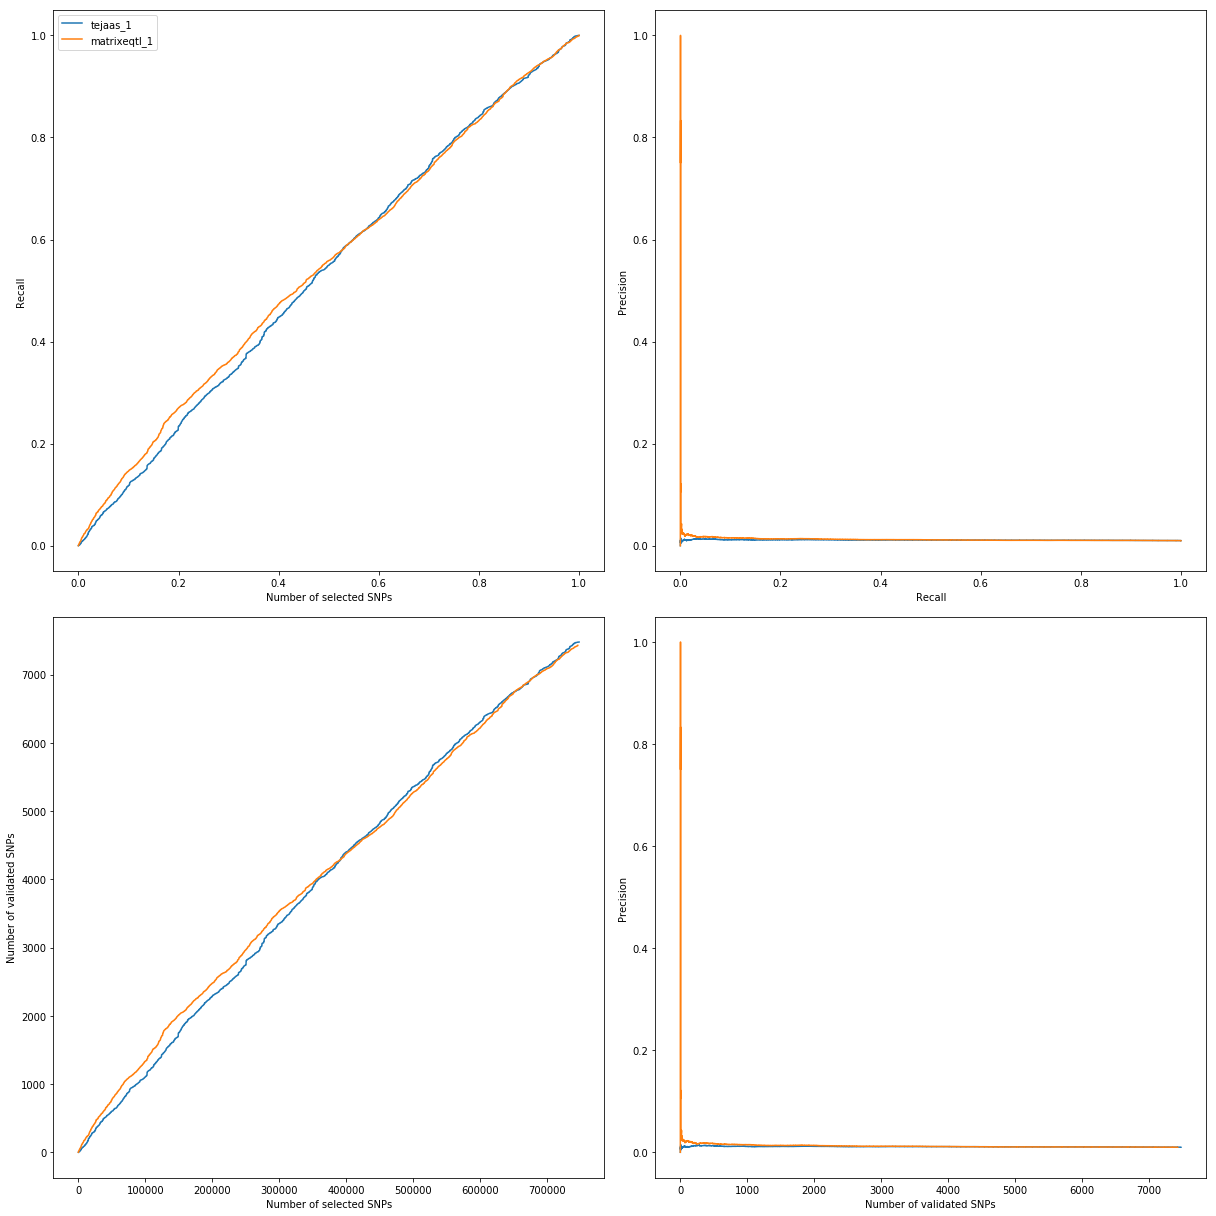

In [124]:

fig = plt.figure(figsize = (17, 17))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

tissue = datasets[0]
outfile = "../plots/partition_test_"+expr+"_"+tissue+".png"

for r in replicas:
    for key in valres[tissue][r].keys():
        nsel, tpr, ppv, valids = roc.confusion_matrix(valres[tissue][r][key])
        scaled_nsel = nsel / max(nsel)
        ax1.plot(scaled_nsel, tpr, label =key+"_"+str(r))
        ax2.plot(tpr, ppv, label = key+"_"+str(r))
        ax3.plot(nsel, valids, label = key+"_"+str(r))
        ax4.plot(valids, ppv, label = key+"_"+str(r))
    
mlabel = r'Number of selected SNPs'
ax1.set_xlabel(mlabel)
ax3.set_xlabel(mlabel)
mlabel = r'Recall'
ax1.set_ylabel(mlabel)
ax2.set_xlabel(mlabel)
mlabel = r'Number of validated SNPs'
ax4.set_xlabel(mlabel)
ax3.set_ylabel(mlabel)
mlabel = r'Precision'
ax2.set_ylabel(mlabel)
ax4.set_ylabel(mlabel)

ax1.legend()
plt.tight_layout()
# plt.savefig(outfile, bbox_inches='tight')
plt.show()

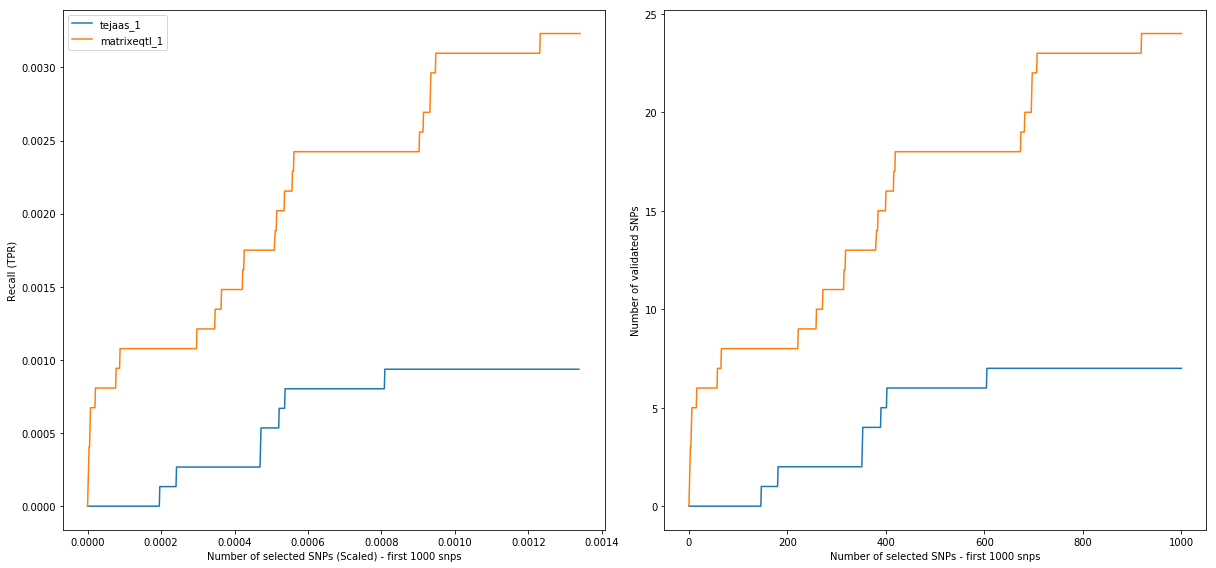

In [125]:
fig = plt.figure(figsize = (17, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

tissue = datasets[0]
outfile = "../plots/partition_test_n1000_"+expr+"_"+tissue+".png"

for r in replicas:
    for key in valres[tissue][r].keys():
        nsel, tpr, ppv, valids = roc.confusion_matrix(valres[tissue][r][key])
        scaled_nsel = nsel / max(nsel)
        #ax1.plot(scaled_nsel, tpr, label = key)
        #ax2.plot(tpr, ppv, label = key)
        Nmax = min(1000, len(nsel)-1)
        ix = nsel < Nmax
        x = np.append(nsel[ ix ], Nmax)
        xscaled  = np.append(scaled_nsel[ ix ], Nmax/max(nsel))

        y = np.append(valids[ ix ], valids[ np.sum(ix)])
        ytpr = np.append(tpr[ ix ],    tpr[ np.sum(ix)])
        ax1.plot(xscaled, ytpr, label = key+"_"+str(r))
        ax2.plot(x, y, label = key+"_"+str(r))

mlabel = r'Number of selected SNPs (Scaled) - first 1000 snps'
ax1.set_xlabel(mlabel)
mlabel = r'Number of selected SNPs - first 1000 snps'
ax2.set_xlabel(mlabel)
mlabel = r'Recall (TPR)'
ax1.set_ylabel(mlabel)
mlabel = r'Number of validated SNPs'
ax2.set_ylabel(mlabel)

ax1.legend()
plt.tight_layout()
# plt.savefig(outfile, bbox_inches='tight')
plt.show()

In [126]:
import pandas as pd

pvallist1 = list()
pvallist2 = list()
for chrom in chrms:
    print(chrom)
    inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/parttest/"+expr+"/gtex-wb/1/tejaas_part1/permnull_sb0.05/chr"+str(chrom)+"/rr.txt"
    df = pd.read_table(inputfile, header=0)
    pvallist1 += list(df.P)
    inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/parttest/"+expr+"/gtex-wb/1/tejaas_part2/permnull_sb0.05/chr"+str(chrom)+"/rr.txt"
    df = pd.read_table(inputfile, header=0)
    pvallist2 += list(df.P)

6
7
8


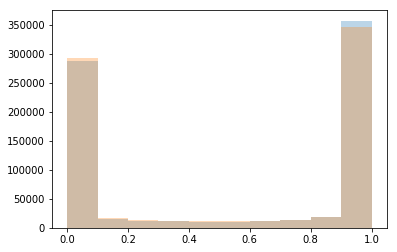

In [127]:
plt.hist(pvallist1, alpha=0.3)
plt.hist(pvallist2, alpha=0.3)
plt.show()

6
7
8


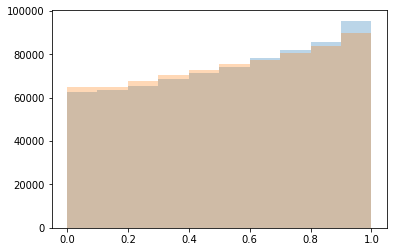

In [140]:
import pandas as pd

pvallist1 = list()
rsidlist1 = list()
pvallist2 = list()
for chrom in chrms:
    print(chrom)
    inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/parttest/"+expr+"/gtex-wb/1/tejaas_part1/permnull_sb0.01/chr"+str(chrom)+"/rr.txt"
    df = pd.read_table(inputfile, header=0)
    pvallist1 += list(df.P)
    rsidlist1 += list(df.ID)
    inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/parttest/"+expr+"/gtex-wb/1/tejaas_part2/permnull_sb0.01/chr"+str(chrom)+"/rr.txt"
    df = pd.read_table(inputfile, header=0)
    pvallist2 += list(df.P)
    
plt.hist(pvallist1, alpha=0.3)
plt.hist(pvallist2, alpha=0.3)
plt.show()

In [134]:
from statsmodels.stats import multitest
reject, bhlist, _a, _b = multitest.multipletests(np.array(pvallist1), method="fdr_bh")


#np.sum(np.array(pvallist1) < 0.05)

In [139]:
np.array(pvallist1)[(bhlist < 0.05)]

array([3.92959e-08])

In [145]:
rsidlist1[np.where(bhlist < 0.05)[0][0]]

'rs10954412'